We use the JuliaImages to handle images in Julia. The documents can be found https://juliaimages.github.io/latest/index.html.

In [1]:
using Images

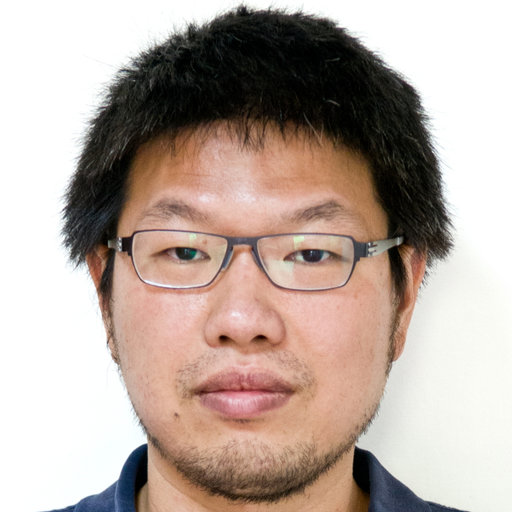

In [2]:
img=load("Lin.jpg")

Create a matrix that to add random noise on the image

In [3]:
B=zeros(size(img,1),size(img,2))
for i=1:size(img,1)
    for j=1:size(img,2)
        if rand() >=0.8
            B[i,j] = 0
        elseif rand() <= 0.2
            B[i,j]=1
        else
            B[i,j]=3
        end
    end
end

Create a image to add Gaussian noise on the image.

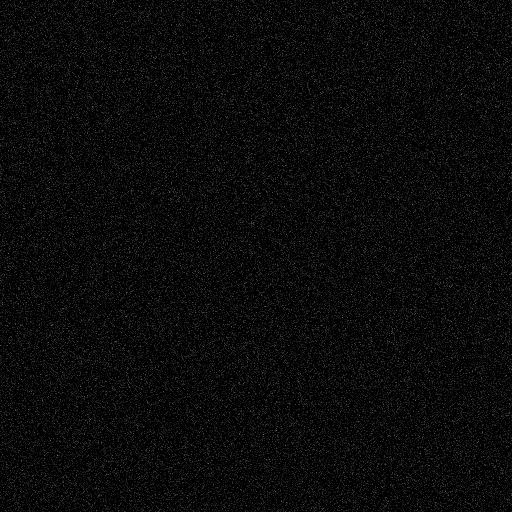

In [4]:
C=Gray.(sqrt(0.01)*(randn(size(img,1),size(img,2))))

add noise on image.

In [5]:
chimg=copy(channelview(img));
for k=1:3
    for i=1:size(img,1)
        for j=1:size(img,2)
            if B[i,j]==0
                chimg[k,i,j]=B[i,j];
            end
            if B[i,j]==1
                chimg[k,i,j]=B[i,j];
            end
        end
    end
end

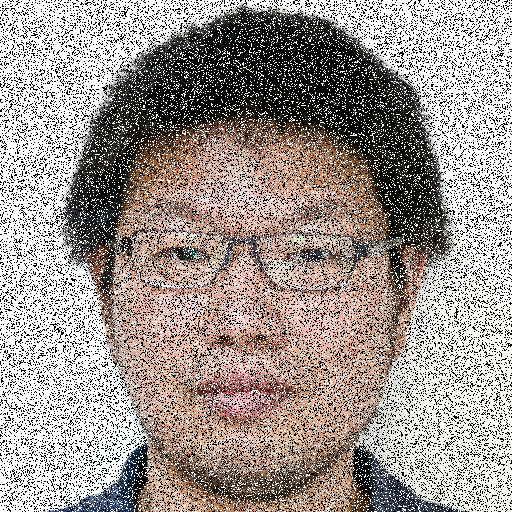

In [6]:
img3 = colorview(RGB,chimg)

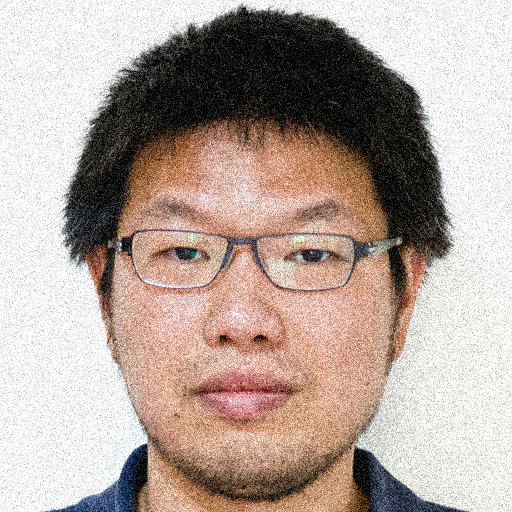

In [7]:
img4 = img.+C

Use channelview to seperate colors.

In [8]:
chimg3=channelview(img3);
chimg4=channelview(img4);

Use mapwindow provied by JuliaImages to do median filtering.

In [9]:
imgB1 = mapwindow(median!,chimg3[1,:,:], (7,7));
imgB2 = mapwindow(median!,chimg3[2,:,:], (7,7));
imgB3 = mapwindow(median!,chimg3[3,:,:], (7,7));
imgB=zeros(3,512,512);
imgB[1,:,:]=imgB1;
imgB[2,:,:]=imgB2;
imgB[3,:,:]=imgB3;

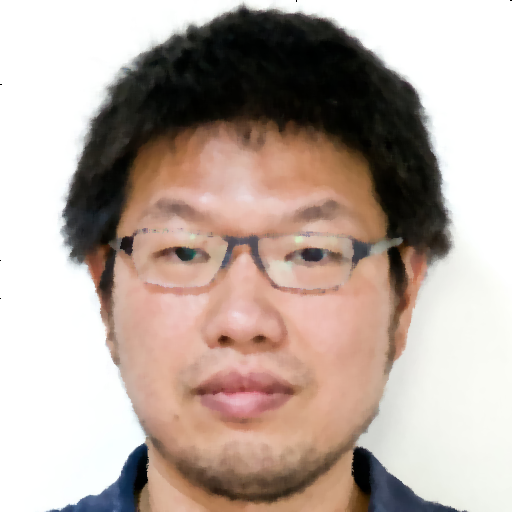

In [10]:
imgBc=colorview(RGB,imgB)

In [11]:
imgC1 = mapwindow(median!,chimg4[1,:,:], (7,7));
imgC2 = mapwindow(median!,chimg4[2,:,:], (7,7));
imgC3 = mapwindow(median!,chimg4[3,:,:], (7,7));
imgC=zeros(3,512,512);
imgC[1,:,:]=imgC1;
imgC[2,:,:]=imgC2;
imgC[3,:,:]=imgC3;

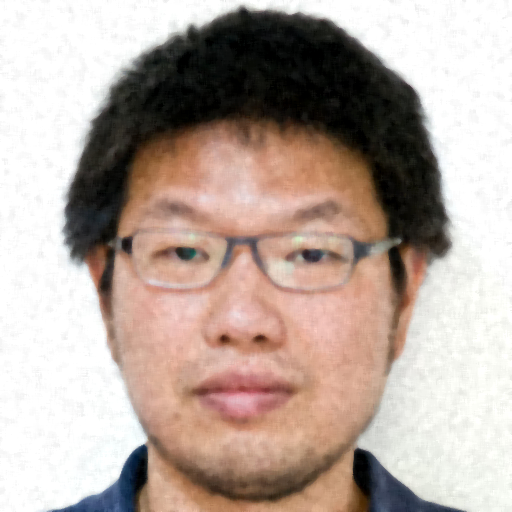

In [12]:
imgCc=colorview(RGB,imgC)

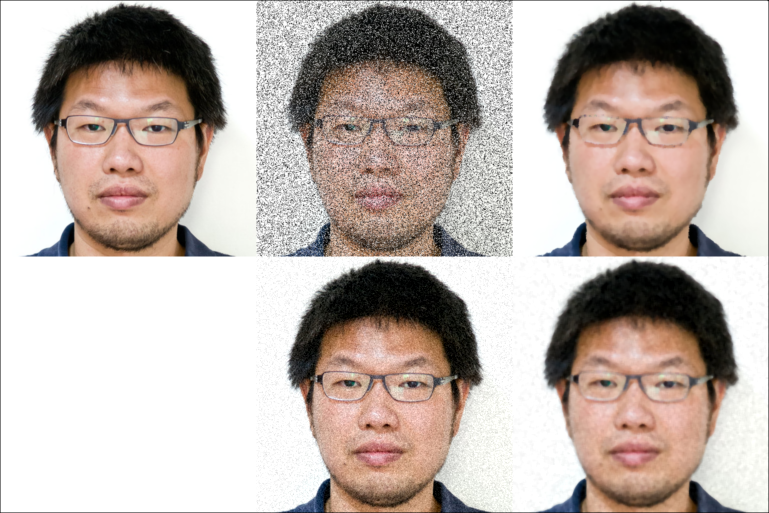

In [13]:
acompare=ones(3,1024,1536);
compare=colorview(RGB,acompare);
compare[1:512,1:512]=img;
compare[1:512,513:1024]=img3;
compare[513:1024,513:1024]=img4;
compare[1:512,1025:1536]=imgBc;
compare[513:1024,1025:1536]=imgCc;
compare

In [14]:
save("img3.png",img3);
save("img4.png",img4);
save("imgBc.png",imgBc);
save("imgCc.png",imgCc);
save("compare.png",compare);

Try `map(clamp01nan, img)` to clamp values to a valid range.
Try `map(clamp01nan, img)` to clamp values to a valid range.
Try `map(clamp01nan, img)` to clamp values to a valid range.


From here we start to use the Primal-Dual algorithm to solve the problem, which can be found in https://github.com/znah/notebooks/blob/master/TV_denoise.ipynb. This is just a Julia revision of the code.

In [15]:
function nabla(x)
    G=zeros(size(x,1),size(x,2),2);
    G[1:size(x,1),1:size(x,2)-1,1]-=x[1:size(x,1),1:size(x,2)-1]
    G[1:size(x,1),1:size(x,2)-1,1]+=x[1:size(x,1),2:size(x,2)]
    G[1:size(x,1)-1,1:size(x,2),2]-=x[1:size(x,1)-1,1:size(x,2)]
    G[1:size(x,1)-1,1:size(x,2),2]+=x[2:size(x,1),1:size(x,2)]
    return G
end

nabla (generic function with 1 method)

In [16]:
function nablaT(G)
    x=zeros(size(G,1),size(G,2))
    x[1:size(x,1),1:size(x,2)-1]-=G[1:size(x,1),1:size(x,2)-1,1]
    x[1:size(x,1),2:size(x,2)]+=G[1:size(x,1),1:size(x,2)-1,1]
    x[1:size(x,1)-1,1:size(x,2)]-=G[1:size(x,1)-1,1:size(x,2),2]
    x[2:size(x,1),1:size(x,2)]+=G[1:size(x,1)-1,1:size(x,2),2]
    return x
end

nablaT (generic function with 1 method)

In [17]:
function anorm(A)
    C=A.*A
    return sqrt.(C[:,:,1]+C[:,:,2])
end

anorm (generic function with 1 method)

In [18]:
function calc_energy_TVL1(X, observation, clambda)
    Ereg=0.
    a = anorm(nabla(X))
    for i in a
        Ereg+=i
    end
    Edata=0.;
    for i=1:size(X,1)
        for j=1:size(X,2)
            Edata=Edata+abs(X[i,j]-observation[i,j])
        end
    end
    Edata=Edata*clambda
    return Ereg + Edata
end

calc_energy_TVL1 (generic function with 1 method)

In [19]:
lambda_TVL1 = 1.0

1.0

In [20]:
function project_nd(P, r)
    nP = max.(1.0, anorm(P)/r)
    return P ./ nP
end

project_nd (generic function with 1 method)

In [21]:
function shrink_1d(X, F, step)
    return X .+ clamp.(F - X, -step, step)
end

shrink_1d (generic function with 1 method)

In [22]:
function solve_TVL1(img, clambda, iter_n=101)
    # setting step sizes and other params
    L2 = 8.0
    tau = 0.02
    sigma = 1.0 / (L2*tau)
    theta = 1.0

    X = copy(img)
    P = nabla(X)
    for i in 1:iter_n
        P = project_nd( P .+ sigma.*nabla(X), 1.0 )
        X1 = shrink_1d(X - tau.*nablaT(P), img, clambda*tau)
        X = X1 .+ theta * (X1 - X)
        if i % 10 == 0
            print(calc_energy_TVL1(X, img, clambda)," ");
        end
    end
    return X
end

solve_TVL1 (generic function with 2 methods)

Our functions are designed for gray scale only, so seperate the colors

In [23]:
chimg3=channelview(img3);

In [24]:
T1=solve_TVL1(chimg3[1,:,:],1,101);
T2=solve_TVL1(chimg3[2,:,:],1,101);
T3=solve_TVL1(chimg3[3,:,:],1,101);

71825.44679504842 60000.2874035878 58461.40073268373 56548.83545365766 56298.767466917554 56609.81613142512 55557.674191834 55861.26902170111 56005.0204349107 55265.56018149457 69452.43350769338 59215.709944962655 57730.827860182886 55821.8105650883 55631.55977152751 56033.767105662395 54923.78259708482 55277.64573290935 55465.4786648897 54660.68777572396 68874.46224633734 58760.27702383352 57297.400282709146 55427.183228250266 55243.55461472517 55601.559081540625 54527.9531306735 54860.80963734287 55017.807744221274 54232.734985715535 

In [25]:
imgT=zeros(3,512,512);
imgT[1,:,:]=T1;
imgT[2,:,:]=T2;
imgT[3,:,:]=T3;

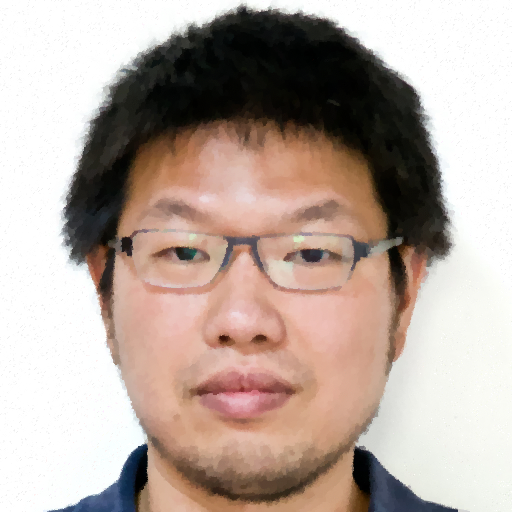

In [26]:
imgTc=colorview(RGB,imgT)

In [27]:
chimg4=channelview(img4);
V1=solve_TVL1(chimg4[1,:,:],1,101);
V2=solve_TVL1(chimg4[2,:,:],1,101);
V3=solve_TVL1(chimg4[3,:,:],1,101);

32258.20720498315 29306.542122472096 27859.190140752802 26930.081087933824 26266.86237726105 25788.291869531036 25446.910058899033 25152.173873805736 24928.187108606642 24745.566236399914 32189.05749826875 29221.72449423603 27771.159922423736 26844.716002322428 26188.42963577217 25717.314677644623 25369.27753941849 25079.104347505032 24853.83947347662 24672.719043538247 32118.143791935487 29132.81652113649 27672.61650691503 26745.652065724033 26086.778455074018 25616.12135434663 25272.839805736578 24973.57607016843 24763.100977127164 24567.600849389226 

In [28]:
imgV=zeros(3,512,512);
imgV[1,:,:]=V1;
imgV[2,:,:]=V2;
imgV[3,:,:]=V3;

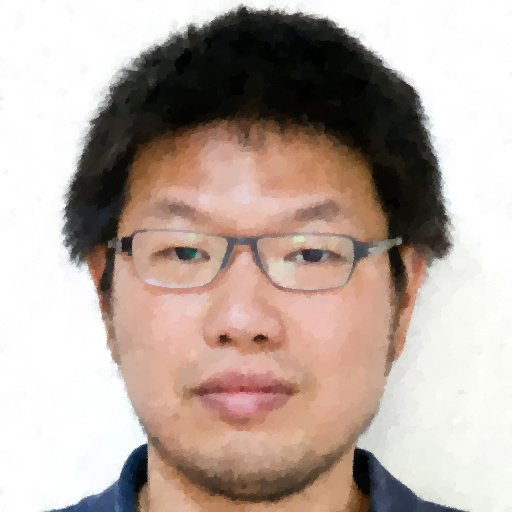

In [29]:
imgVc=colorview(RGB,imgV)

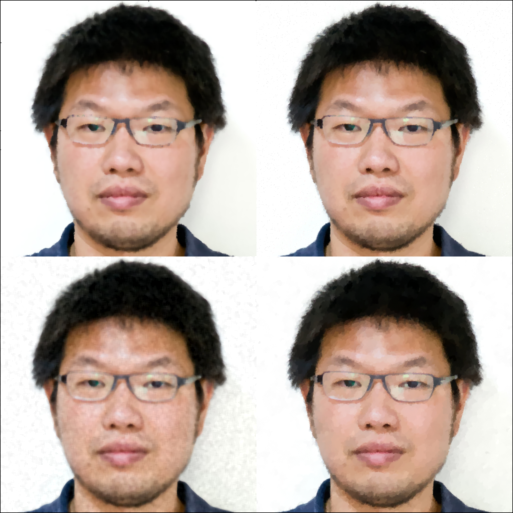

In [30]:
acompare2=ones(3,1024,1024);
compare2=colorview(RGB,acompare2);
compare2[1:512,1:512]=imgBc;
compare2[513:1024,1:512]=imgCc;
compare2[1:512,513:1024]=imgTc;
compare2[513:1024,513:1024]=imgVc;
compare2

In [31]:
save("imgTc.png",imgTc);
save("imgVc.png",imgVc);
save("compare2.png",compare2);

Try `map(clamp01nan, img)` to clamp values to a valid range.
Try `map(clamp01nan, img)` to clamp values to a valid range.
Try `map(clamp01nan, img)` to clamp values to a valid range.
